# Importing Libraries

In [47]:
import numpy as np
import keras
import tensorflow as tf 
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt


from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau

In [48]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [49]:
input_shape = x_train.shape[1:]

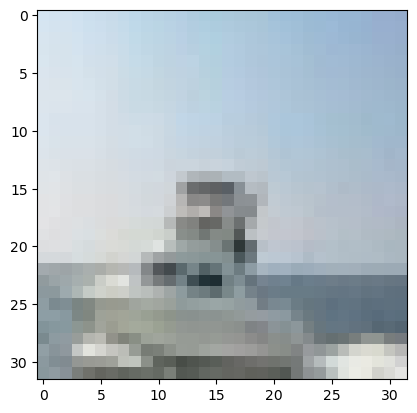

In [50]:
plt.imshow(x_train[100])

In [51]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [52]:
# convert from integers to floats
train_norm = x_train.astype('float32')
test_norm = x_test.astype('float32')

In [53]:
#Normalizing Images
x_train = train_norm / 255
x_test = test_norm / 255

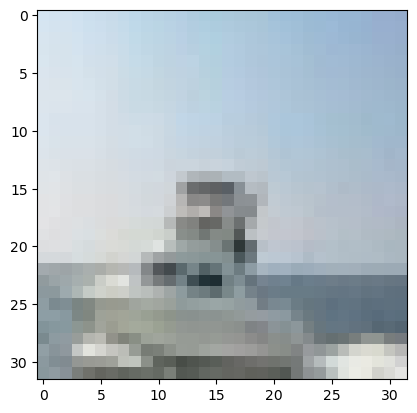

In [54]:
plt.imshow(x_train[100])

In [55]:
#Setting Subtract_pixel=True
subtract_pixel_mean = True

In [56]:
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [57]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


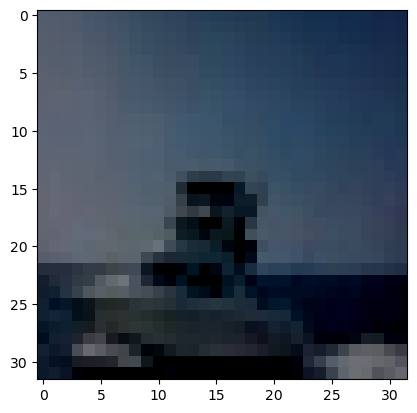

In [58]:
plt.imshow(x_train[100])

# Modified the n=3 to n=5 the param that chnages the mode depth Value

In [107]:
#Modified the n=3 to n=5 the param that chnages the mode depth Value
def model_depth(version,n):
    """
    Computes depth from supplied model parameter n
    """
    if version == 1:
        depth = n * 6 + 2
        #print(depth)
    elif version == 2:
        depth = n * 9 + 2
        #print(depth)
    return depth

In [60]:
def model_type(version,n):
    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (model_depth(version,n), version)
    return model_type

In [61]:
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [62]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [63]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    print(num_res_blocks)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [64]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    #depth is changes so the number of res_blocks
    num_res_blocks = int((depth - 2) / 9)
    print(num_res_blocks)
    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [65]:
def choose_model(version=1):
#    Chooses the model based on version
    
    if version == 2:
        model = resnet_v2(input_shape=input_shape, depth=depth)
    else:
        model = resnet_v1(input_shape=input_shape, depth=depth)
    return model

In [70]:
version = 1
n = 3

In [71]:
depth = model_depth(version=version,n=n)
print(depth)
model = choose_model(version)

20
3


In [72]:
print(model_type(version,n))

ResNet20v1


In [93]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_100 (Conv2D)            (None, 32, 32, 16)   448         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_83 (BatchN  (None, 32, 32, 16)  64          ['conv2d_100[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_83 (Activation)     (None, 32, 32, 16)   0           ['bat

                                                                                                  
 batch_normalization_92 (BatchN  (None, 16, 16, 32)  128         ['conv2d_110[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_92 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 conv2d_111 (Conv2D)            (None, 16, 16, 32)   9248        ['activation_92[0][0]']          
                                                                                                  
 batch_normalization_93 (BatchN  (None, 16, 16, 32)  128         ['conv2d_111[0][0]']             
 ormalization)                                                                                    
          

                                                                                                  
 activation_101 (Activation)    (None, 8, 8, 64)     0           ['add_47[0][0]']                 
                                                                                                  
 average_pooling2d_4 (AveragePo  (None, 1, 1, 64)    0           ['activation_101[0][0]']         
 oling2D)                                                                                         
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d_4[0][0]']    
                                                                                                  
 dense_4 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

In [94]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [95]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_freq=48
                            )

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [96]:
callbacks = [lr_reducer, lr_scheduler]

In [97]:
from time import time

In [98]:
batch_size = 48  # orig paper trained all networks with batch_size=128
epochs = 5

In [99]:
t1 = time()
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time()

Learning rate:  0.001
Epoch 1/5
1042/1042 [==============================] - 572s 544ms/step - loss: 1.5047 - accuracy: 0.5093 - val_loss: 1.2883 - val_accuracy: 0.5946 - lr: 0.0010
Learning rate:  0.001
Epoch 2/5
1042/1042 [==============================] - 669s 642ms/step - loss: 1.0901 - accuracy: 0.6691 - val_loss: 1.2377 - val_accuracy: 0.6222 - lr: 0.0010
Learning rate:  0.001
Epoch 3/5
1042/1042 [==============================] - 1024s 983ms/step - loss: 0.9131 - accuracy: 0.7359 - val_loss: 1.1688 - val_accuracy: 0.6716 - lr: 0.0010
Learning rate:  0.001
Epoch 4/5
1042/1042 [==============================] - 959s 920ms/step - loss: 0.8061 - accuracy: 0.7763 - val_loss: 1.0138 - val_accuracy: 0.7064 - lr: 0.0010
Learning rate:  0.001
Epoch 5/5
1042/1042 [==============================] - 680s 653ms/step - loss: 0.7349 - accuracy: 0.8009 - val_loss: 1.0523 - val_accuracy: 0.7071 - lr: 0.0010


In [101]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 5 epochs took 65.1 minutes total.


In [102]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 37s 117ms/step - loss: 1.0523 - accuracy: 0.7071
Test loss: 1.0522524118423462
Test accuracy: 0.707099974155426


In [103]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
        
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

 For Version2 setting n=5 so that the depth changes and so does the no. of blocks changes

In [118]:
version = 2
n = 5

In [119]:
depth = model_depth(version=version,n=n)
model = choose_model(version)

5


In [120]:
print(model_type(version,n))

ResNet47v2


In [121]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 32, 32, 16)   448         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_166 (Batch  (None, 32, 32, 16)  64          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_166 (Activation)    (None, 32, 32, 16)   0           ['bat

                                                                                                  
 activation_175 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_175[0][0]']
                                                                                                  
 conv2d_199 (Conv2D)            (None, 32, 32, 16)   1040        ['activation_175[0][0]']         
                                                                                                  
 batch_normalization_176 (Batch  (None, 32, 32, 16)  64          ['conv2d_199[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_176 (Activation)    (None, 32, 32, 16)   0           ['batch_normalization_176[0][0]']
                                                                                                  
 conv2d_20

                                                                                                  
 conv2d_210 (Conv2D)            (None, 16, 16, 64)   36928       ['activation_185[0][0]']         
                                                                                                  
 batch_normalization_186 (Batch  (None, 16, 16, 64)  256         ['conv2d_210[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_186 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_186[0][0]']
                                                                                                  
 conv2d_211 (Conv2D)            (None, 16, 16, 128)  8320        ['activation_186[0][0]']         
                                                                                                  
 add_75 (A

                                                                  'conv2d_220[0][0]']             
                                                                                                  
 batch_normalization_196 (Batch  (None, 16, 16, 128)  512        ['add_78[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 activation_196 (Activation)    (None, 16, 16, 128)  0           ['batch_normalization_196[0][0]']
                                                                                                  
 conv2d_221 (Conv2D)            (None, 8, 8, 128)    16512       ['activation_196[0][0]']         
                                                                                                  
 batch_normalization_197 (Batch  (None, 8, 8, 128)   512         ['conv2d_221[0][0]']             
 Normaliza

 batch_normalization_206 (Batch  (None, 8, 8, 128)   512         ['conv2d_231[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_206 (Activation)    (None, 8, 8, 128)    0           ['batch_normalization_206[0][0]']
                                                                                                  
 conv2d_232 (Conv2D)            (None, 8, 8, 128)    147584      ['activation_206[0][0]']         
                                                                                                  
 batch_normalization_207 (Batch  (None, 8, 8, 128)   512         ['conv2d_232[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

In [122]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [125]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_freq=32
                            )

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [126]:
callbacks = [lr_reducer, lr_scheduler]

In [127]:
from time import time

In [128]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 2

In [129]:
t1 = time()
resnet_his=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
t2 = time()

Learning rate:  0.001
Epoch 1/2
1563/1563 [==============================] - 1650s 1s/step - loss: 1.9423 - accuracy: 0.5180 - val_loss: 1.6061 - val_accuracy: 0.5814 - lr: 0.0010
Learning rate:  0.001
Epoch 2/2
1563/1563 [==============================] - 1119s 716ms/step - loss: 1.3330 - accuracy: 0.6714 - val_loss: 1.2373 - val_accuracy: 0.6897 - lr: 0.0010


In [130]:
time_delta=round((t2-t1)/60,2)

print ("Training of {} epochs took {} minutes total.".format(epochs, time_delta))

Training of 2 epochs took 46.17 minutes total.


In [131]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 63s 202ms/step - loss: 1.2373 - accuracy: 0.6897
Test loss: 1.2372633218765259
Test accuracy: 0.6897000074386597


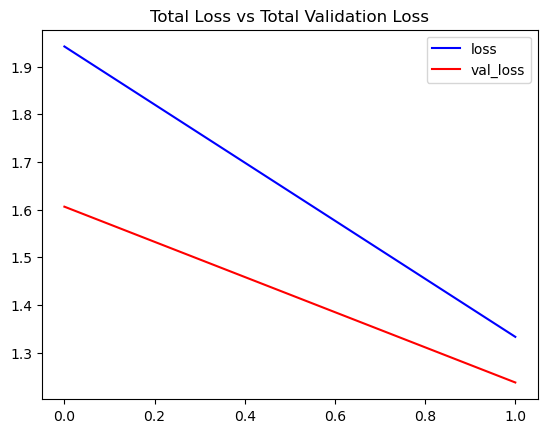

In [132]:
from tensorflow.keras.utils import plot_model
# Visualize the training and validation loss metrices.
plot_metric(resnet_his, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

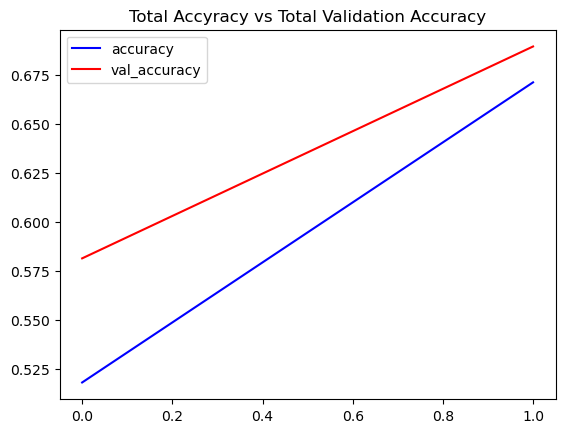

In [133]:
# Visualize the training and validation accuracy metrices.
plot_metric(resnet_his, 'accuracy', 'val_accuracy', 'Total Accyracy vs Total Validation Accuracy')